<h1 align="center">NYC Taxi Fare And Duration Prediction- Analysis</h1>

<font color='blueviolet'><h2>Taxi Data Importing</h2></font>

In [1]:
#ucitavanje potrebnih biblioteka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm
import holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calander

In [2]:
#ucitavanje podataka iz 2016.godine za mjesec maj
taxi_data=pd.read_parquet('yellow_tripdata_2016-05.parquet',engine='fastparquet')

<font color='blueviolet'><h2>Data Wrangling</h2></font>

<h3><font color="lightcoral">Podaci prije obrade</font></h3>

In [3]:
#ispis prvih pet redova 
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2016-05-01 00:07:41,2016-05-01 00:08:25,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80,NaN,NaN
1,1,2016-05-01 00:09:08,2016-05-01 00:09:58,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80,NaN,NaN
2,1,2016-05-01 00:01:47,2016-05-01 00:05:27,1,0.9,1,N,166,238,2,5.5,0.5,0.5,0.0,0.00,0.3,6.80,NaN,NaN
3,1,2016-05-01 00:11:46,2016-05-01 00:25:35,1,2.0,1,N,151,74,2,11.0,0.5,0.5,0.0,0.00,0.3,12.30,NaN,NaN
4,1,2016-05-01 00:30:45,2016-05-01 00:40:08,2,5.2,1,N,74,129,2,15.5,0.5,0.5,0.0,5.54,0.3,22.34,NaN,NaN


In [4]:
#Ispis broja uzoraka i broja obilježja
print("Broj uzoraka:",taxi_data.shape[0],"\n")
print("Broj obilježja:",taxi_data.shape[1],"\n")
#Tipovi podataka svakog obilježja
taxi_data.dtypes


Broj uzoraka: 11832049 

Broj obilježja: 19 



VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

<h3><font color="royalblue">Obrada podataka</font></h3>

In [5]:
#Provjera da li ima nedostajucih podataka 
null=taxi_data.isnull().sum().sort_values(ascending=False)
print("Nedostajući podaci po svakom obilježju:\n",null)

Nedostajući podaci po svakom obilježju:
 airport_fee              11832049
congestion_surcharge     11832049
fare_amount                     0
total_amount                    0
improvement_surcharge           0
tolls_amount                    0
tip_amount                      0
mta_tax                         0
extra                           0
VendorID                        0
tpep_pickup_datetime            0
DOLocationID                    0
PULocationID                    0
store_and_fwd_flag              0
RatecodeID                      0
trip_distance                   0
passenger_count                 0
tpep_dropoff_datetime           0
payment_type                    0
dtype: int64


<h3>Izbacivanje nedostajucih podataka</h3>
Na osnovu prikaza iznad moze se primjetiti da su nedostajuci podaci prisutni u dva obiljezja (airport_fee, congestion_surcharge). Ukupan broj NaN podataka je jednak ukupnom broju uzoraka odnosno za ta obiljezje nemamo podata pa cemo ih izbaciti

In [6]:
#Izbacivanje kolona koje imaju sve NaN vrijednosti
taxi_data.drop(['airport_fee','congestion_surcharge'],inplace=True,axis=1)
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:07:41,2016-05-01 00:08:25,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80
1,1,2016-05-01 00:09:08,2016-05-01 00:09:58,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80
2,1,2016-05-01 00:01:47,2016-05-01 00:05:27,1,0.9,1,N,166,238,2,5.5,0.5,0.5,0.0,0.00,0.3,6.80
3,1,2016-05-01 00:11:46,2016-05-01 00:25:35,1,2.0,1,N,151,74,2,11.0,0.5,0.5,0.0,0.00,0.3,12.30
4,1,2016-05-01 00:30:45,2016-05-01 00:40:08,2,5.2,1,N,74,129,2,15.5,0.5,0.5,0.0,5.54,0.3,22.34


<h3>Izbacivanje nerelevantnih obiljezja</h3>
Posto cemo vrsiti predikciju obiljezja fare_amount, a ne total_amount, obiljezja koja se odnose na dodatne troskove cemo izbaciti

In [7]:
#Izbacivanje obiljezja koja ne uticu direktno na fare_amout 
taxi_data.drop(['store_and_fwd_flag','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount'],inplace=True,axis=1)

In [8]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount'],
      dtype='object')

<h3>Transformacija postojecih i dodavanje novih obiljezja</h3>

In [36]:
# razlaganje datetime na posebna vremenska obiljezja
#taxi_data['pickup_date']=taxi_data['tpep_pickup_datetime'].dt.date.astype(str)
taxi_data['pickup_date']=taxi_data['tpep_pickup_datetime'].dt.date
taxi_data['pickup_time']=taxi_data['tpep_pickup_datetime'].dt.time
taxi_data['dropoff_date']=taxi_data['tpep_dropoff_datetime'].dt.date
taxi_data['dropoff_time']=taxi_data['tpep_dropoff_datetime'].dt.time
taxi_data['week_day']=taxi_data['tpep_pickup_datetime'].dt.dayofweek
taxi_data.loc[taxi_data['week_day']<5,'day_type']=1
taxi_data.loc[taxi_data['week_day']>=5,'day_type']=2

In [37]:
taxi_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
pickup_date                      object
pickup_time                      object
dropoff_date                     object
dropoff_time                     object
week_day                          int64
day_type                        float64
dtype: object

<h3>Ubacivanje praznika</h3>
Ako neki dan u datom skupu podataka je praznik, trebalo bi to oznaciti, jer moze da utice na voznje taj daj(zbog saobracaja mogu voznje biti duze/krace/jeftinije). Potrebno je sve voznje tog dana oznaciti da su u vrijeme praznika.

In [39]:
#dobavljanje praznika za 
cal = calander()
holidays_US = cal.holidays(start='2016-05-01', end='2016-05-31')
holidays_data=[]
for holiday in holidays_US:
    holidays_data.append(holiday.date())
holidays_data

[datetime.date(2016, 5, 30)]

In [40]:
#ispis praznika u 2016
import holidays
for ptr in holidays.US(years =2016 ).items():
    print(ptr)

(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 1, 18), 'Martin Luther King Jr. Day')
(datetime.date(2016, 2, 15), "Washington's Birthday")
(datetime.date(2016, 5, 30), 'Memorial Day')
(datetime.date(2016, 7, 4), 'Independence Day')
(datetime.date(2016, 9, 5), 'Labor Day')
(datetime.date(2016, 10, 10), 'Columbus Day')
(datetime.date(2016, 11, 11), 'Veterans Day')
(datetime.date(2016, 11, 24), 'Thanksgiving')
(datetime.date(2016, 12, 25), 'Christmas Day')
(datetime.date(2016, 12, 26), 'Christmas Day (Observed)')


In [41]:
#postavljanje tipa dana na praznik
taxi_data.loc[(taxi_data['pickup_date'].isin(holidays_data)) == True, 'day_type'] = 3

In [42]:
taxi_data.groupby(by='day_type')['VendorID'].count()

day_type
1.0    8105929
2.0    3465027
3.0     261093
Name: VendorID, dtype: int64

<font color='darkblue'>1- radni dan <br>
2- vikend <br>
3- praznik <br></font>

<h3>Ubacivanje u kom dijelu dana je bila svaka voznja</h3>

<h4><font color="green">FUNCKIJA - za definisanje dijela dana na osnovu sata</font></h4>
<hr>

In [43]:
def day_time_slots(x):
    if x in range(5,9):
        return 1  #Early Morning
    elif x in range(9,13):
        return 2  #Late Morning
    elif x in range(13,16):
        return 3  #Early Afternoon
    elif x in range(16,19):
        return 4  #Late Afternoon
    elif x in range(19,22):
        return 5  #Evening
    else:
        return 6  #Night

<hr>

<h3>Dodavanje obiljezja za period u danu</h3>

In [44]:
#dodavanje obiljezja za dio dana
taxi_data['day_time_slot'] = (taxi_data['tpep_pickup_datetime'].dt.hour).apply(day_time_slots)

In [45]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,week_day,day_type,day_time_slot
0,1,2016-05-01 00:07:41,2016-05-01 00:08:25,1,0.0,1,145,145,2,2.5,2016-05-01,00:07:41,2016-05-01,00:08:25,6,2.0,6
1,1,2016-05-01 00:09:08,2016-05-01 00:09:58,1,0.0,1,145,145,2,2.5,2016-05-01,00:09:08,2016-05-01,00:09:58,6,2.0,6
2,1,2016-05-01 00:01:47,2016-05-01 00:05:27,1,0.9,1,166,238,2,5.5,2016-05-01,00:01:47,2016-05-01,00:05:27,6,2.0,6
3,1,2016-05-01 00:11:46,2016-05-01 00:25:35,1,2.0,1,151,74,2,11.0,2016-05-01,00:11:46,2016-05-01,00:25:35,6,2.0,6
4,1,2016-05-01 00:30:45,2016-05-01 00:40:08,2,5.2,1,74,129,2,15.5,2016-05-01,00:30:45,2016-05-01,00:40:08,6,2.0,6


<h3>Dodavanje obiljezja za trajanje voznje</h3>

In [46]:
#dodavanje obiljezja za trajanje voznje u minutama
taxi_data['duration'] = taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']
taxi_data['duration'] = taxi_data['duration'] / np.timedelta64(1, 'm')
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,week_day,day_type,day_time_slot,duration
0,1,2016-05-01 00:07:41,2016-05-01 00:08:25,1,0.0,1,145,145,2,2.5,2016-05-01,00:07:41,2016-05-01,00:08:25,6,2.0,6,0.733333
1,1,2016-05-01 00:09:08,2016-05-01 00:09:58,1,0.0,1,145,145,2,2.5,2016-05-01,00:09:08,2016-05-01,00:09:58,6,2.0,6,0.833333
2,1,2016-05-01 00:01:47,2016-05-01 00:05:27,1,0.9,1,166,238,2,5.5,2016-05-01,00:01:47,2016-05-01,00:05:27,6,2.0,6,3.666667
3,1,2016-05-01 00:11:46,2016-05-01 00:25:35,1,2.0,1,151,74,2,11.0,2016-05-01,00:11:46,2016-05-01,00:25:35,6,2.0,6,13.816667
4,1,2016-05-01 00:30:45,2016-05-01 00:40:08,2,5.2,1,74,129,2,15.5,2016-05-01,00:30:45,2016-05-01,00:40:08,6,2.0,6,9.383333


<h3>Pretvaranje milja u kilometre</h3>

In [47]:
#pretvaranje miles to km
taxi_data['trip_distance']=taxi_data['trip_distance']*1.609

#izracunavanje prosjecne brzine na osnovu predjenog puta i trajanje voznje u km/h
taxi_data['avg_speed']=taxi_data['trip_distance']/(taxi_data['duration']/60)

<h3>Izbacivanje pocetnih obiljezja sa datumom i vremenom</h3>

In [48]:
#Izbacivanje pocetna obiljezja sa datumom i vremenom
taxi_data.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1, inplace=True)

In [20]:
taxi_data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time',
       'week_day', 'day_type', 'day_time_slot', 'duration', 'avg_speed'],
      dtype='object')

<font color='blueviolet'><h2>Feature Analysis</h2></font>

<font color='royalblue'><h3>Kategoricka obiljezja</h3></font>

In [49]:
#Ispis vrijednosti za kategoricka obiljezja 
print('RatecodeID values:',taxi_data['RatecodeID'].unique())
print('Passenger_count values:',taxi_data['passenger_count'].unique())
print('Payment_type values:',taxi_data['payment_type'].unique())
print('Week_day values:',taxi_data['week_day'].unique())
print('Day_type values:',taxi_data['day_type'].unique())
print('Day_time_slot values:',taxi_data['day_time_slot'].unique())

RatecodeID values: [ 1  2  5  3  4  6 99]
Passenger_count values: [1 2 3 4 6 5 0 8 7 9]
Payment_type values: [2 1 3 4 5]
Week_day values: [6 0 1 2 3 4 5]
Day_type values: [2. 1. 3.]
Day_time_slot values: [6 1 2 3 4 5]


Na osnovu vrijednosti koje su izlistane iznad, moze se uociti da za ratecodeID postoji jedna nevalidna vrijednost=99. Takodje nema smisla da se gledaju voznje gdje je broj putnika 0.

In [50]:
print('Broj voznji sa nevalidnim RatecodeId:',taxi_data[taxi_data['RatecodeID']==99]['RatecodeID'].count())
print('Broj voznji sa 0 putnika:',taxi_data[taxi_data['passenger_count']==0]['passenger_count'].count())

Broj voznji sa nevalidnim RatecodeId: 362
Broj voznji sa 0 putnika: 602


In [51]:
#uklanjanje nevalidnih voznji za RatecodeID i passenger_count
taxi_data=taxi_data[(taxi_data['RatecodeID']!=99) & (taxi_data['passenger_count']!=0)]

<font color='royalblue'><h3>Numericka obiljezja</h3></font>

In [52]:
#statistika za numericka obiljezja
taxi_data[['trip_distance','fare_amount','duration','avg_speed']].describe()

,trip_distance,fare_amount,duration,avg_speed
count,1.183117e+07,1.183117e+07,1.183117e+07,1.181964e+07
mean,9.835516e+00,1.334207e+01,1.667657e+01,inf
std,8.296648e+03,1.174657e+01,1.173282e+02,NaN
min,0.000000e+00,-4.100000e+02,-1.364710e+05,-4.054680e+03
25%,1.609000e+00,6.500000e+00,6.783333e+00,1.201743e+01
50%,2.767480e+00,9.500000e+00,1.146667e+01,1.658481e+01
75%,5.261430e+00,1.500000e+01,1.885000e+01,2.269995e+01
max,1.930801e+07,8.007000e+03,1.009343e+04,inf


In [53]:
print('Broj voznji sa rastojanjem 0:',taxi_data[taxi_data['trip_distance']==0]['trip_distance'].count())
print('Broj voznji sa trajanjem <= 0:',taxi_data[taxi_data['duration']<=0]['duration'].count())
print('Broj voznji sa cijenom <= 0:',taxi_data[taxi_data['fare_amount']<=0]['fare_amount'].count())

Broj voznji sa rastojanjem 0: 67396
Broj voznji sa trajanjem <= 0: 11921
Broj voznji sa cijenom <= 0: 7928


Na osnovu statistickih vrijednosti, primjecuju se odredjena odstupanja :
<li> Minimalna vrijednsot za duzinu puta je 0 (67396 uzoraka)</li>
<li> Minimalna vrijednost za trajanje je negativna </li>
<li> Postoje voznje sa negativnom cijenom </li>

In [54]:
#uklanjanje voznji sa nevalidnim podacima 
taxi_data=taxi_data[ (taxi_data['trip_distance']!=0) & (taxi_data['duration']>0) & (taxi_data['fare_amount']>0)]

In [55]:
print('Broj voznji sa rastojanjem 0:',taxi_data[taxi_data['trip_distance']==0]['trip_distance'].count())
print('Broj voznji sa trajanjem <= 0:',taxi_data[taxi_data['duration']<=0]['duration'].count())
print('Broj voznji sa cijenom <= 0:',taxi_data[taxi_data['fare_amount']<=0]['fare_amount'].count())

Broj voznji sa rastojanjem 0: 0
Broj voznji sa trajanjem <= 0: 0
Broj voznji sa cijenom <= 0: 0


In [56]:
#statistika numerickih obiljezja nakon izbacivanja nevalidnih vrijednosti
taxi_data[['trip_distance','fare_amount','duration','avg_speed']].describe()

,trip_distance,fare_amount,duration,avg_speed
count,1.175745e+07,1.175745e+07,1.175745e+07,1.175745e+07
mean,9.893916e+00,1.330569e+01,1.684082e+01,2.374125e+02
std,8.322616e+03,1.143628e+01,5.485302e+01,5.139559e+05
min,1.609000e-02,1.000000e-02,1.666667e-02,6.708049e-04
25%,1.641180e+00,6.500000e+00,6.850000e+00,1.208592e+01
50%,2.799660e+00,9.500000e+00,1.151667e+01,1.662890e+01
75%,5.309700e+00,1.500000e+01,1.891667e+01,2.273652e+01
max,1.930801e+07,8.007000e+03,1.009343e+04,1.616435e+09


<h4><font color="green">FUNCKIJA - za iscrtavanje histograma i boxplot-a</font></h4>
<hr>

In [57]:
def data_distribution(data, label):
   
    x = np.array(data)
    
    fig = plt.figure()
    
    # histogram
    ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6])
    ax1 = plt.hist(x, bins=30)
    plt.grid(alpha=.5)
    
    # boxplot
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])
    ax2 = plt.boxplot(x, vert=False, widths=0.7)
    plt.grid(alpha=.5)
    
    plt.xlabel(label)
    plt.show()

### Passenger count

In [58]:
#broj uzoraka po broju putnika u taksiju tokom jedne voznje
passenger_counts=taxi_data.groupby(['passenger_count']).count()
passenger_counts['VendorID']

passenger_count
1    8295092
2    1730042
3     498464
4     232500
5     623444
6     377878
7         12
8          5
9         15
Name: VendorID, dtype: int64

In [59]:
#broj putnika izrazen u procentima
passenger_counts['VendorID']/(passenger_counts['VendorID'].sum())*100

passenger_count
1    70.551783
2    14.714430
3     4.239558
4     1.977469
5     5.302543
6     3.213945
7     0.000102
8     0.000043
9     0.000128
Name: VendorID, dtype: float64

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

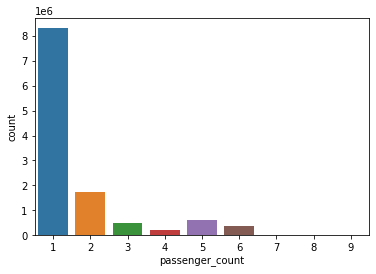

In [60]:
sb.countplot(x=taxi_data["passenger_count"])

Na osnovu prikazanog dijagrama, moze se uociti da je vecina voznji bila sa jednim putnikom i to cak 70,5%. Voznji sa dva putnika je 14.7%, dok su ostale vrijdednosti jako male. 
Vidi se da postoje voznje sa cak 9 putnika. Za brojeve putnika vece od 6 procenti su manji od 0.0002.

In [61]:
#uporedjivanje broja putnika sa predjenim putem i cijenom prevoza 
taxi_data.groupby('passenger_count')['trip_distance', 'fare_amount'].mean()

C:\Users\Natalija\AppData\Local\Temp\ipykernel_13060\1834321843.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  taxi_data.groupby('passenger_count')['trip_distance', 'fare_amount'].mean()


,trip_distance,fare_amount
passenger_count,,
1,10.444757,13.098225
2,12.052338,14.059720
3,5.118922,13.680084
4,5.195834,13.840389
5,5.128689,13.502563
6,4.970715,13.256759
7,11.529826,34.318333
8,23.690916,83.000000
9,20.054576,57.820000


Za voznje sa brojem putnika do 6, vidimo da obicno prelaze slicne distance i cijena je slicna, dok se za broj putnika od 7 cijena drasticno povecava, cak se i prelaze duze staze.


S obzirom na istrazivanja na internetu, iako je po zakonu zabranjeno da se u obicnom taksiju vozi vise od 4 osobe, postoje vozila koja imaju veci broj sjedista za cak 8 osoba, tako da voznje sa velikim brojem putnika iako ih je jako malo nece biti izbacene

<h3>Avg_speed</h3>

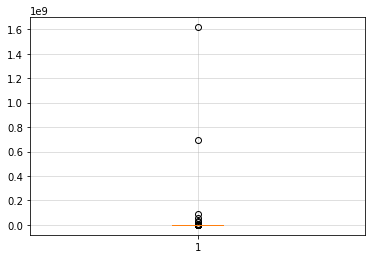

In [62]:
x = np.array(taxi_data['avg_speed'])
    
fig = plt.figure()
    
plt.boxplot(x)
plt.grid(alpha=.5)
           
plt.show()

Posto se vidi da imamo ocigledne outliere za brzinu koja je u km/hm te outliere cemo izbaciti. Izbacicemo sve brzine koje su >=100km/h

In [63]:
taxi_data=taxi_data[taxi_data['avg_speed']<100]

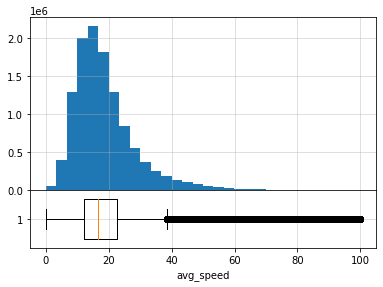

In [64]:
data_distribution(taxi_data['avg_speed'],'avg_speed')

Moze se primjetiti da je raspon prosjecne brzine 10-25km/h. To djeluje sporo, ali kada se takodje uracuna i saobracaj i duzina trajanja voznje, zapravo ne zvuci nerealno.

In [65]:
taxi_data['avg_speed'].describe()

count    1.174614e+07
mean     1.875856e+01
std      1.001432e+01
min      6.708049e-04
25%      1.208075e+01
50%      1.662095e+01
75%      2.271529e+01
max      9.992995e+01
Name: avg_speed, dtype: float64

In [66]:
print('Broj voznji sa prosjecnom brzinom >24km/h:',taxi_data[taxi_data['avg_speed']> 24]['avg_speed'].count())
print('Broj voznji sa prosjecnom brzinom <=24km/h:',taxi_data[taxi_data['avg_speed']<=24]['avg_speed'].count())

Broj voznji sa prosjecnom brzinom >24km/h: 2533152
Broj voznji sa prosjecnom brzinom <=24km/h: 9212986


<h3> Trip_distance </h3>

In [67]:
taxi_data["trip_distance"].describe()

count    1.174614e+07
mean     4.943472e+00
std      6.051340e+00
min      1.609000e-02
25%      1.641180e+00
50%      2.799660e+00
75%      5.309700e+00
max      4.143175e+02
Name: trip_distance, dtype: float64

##### Prije izvrsavanja izbacivanja avg_speed>100km/h statistika za trip_distance je bila:
max: 19 308 000km <br>
srednja vrijednost: 9.89km a <br>
medijan: 2.79km <br> 
sto znaci da postoje autlajeri koji znantno veci od prosjecne duzine puta
##### Dok nakon izvrsavanja svi ti outlier-i sto su bili su nestali i skup sada ima realnije podatke i vrijednosti

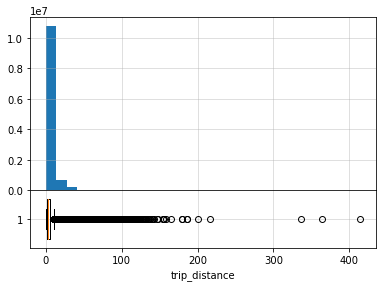

In [68]:
#raspodjela vrijednosti za trip_distance
data_distribution(taxi_data['trip_distance'],'trip_distance')

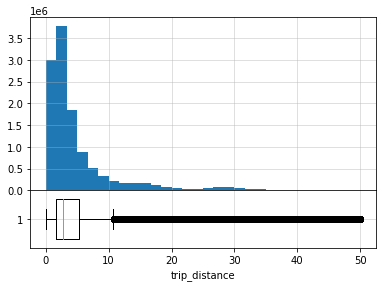

In [69]:
data_distribution(taxi_data['trip_distance'][taxi_data["trip_distance"] <= 50],'trip_distance')

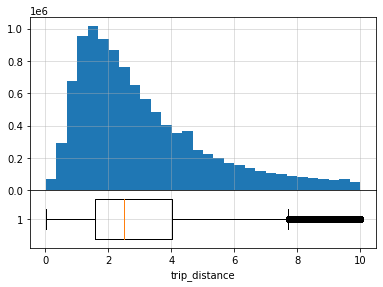

In [70]:
data_distribution(taxi_data['trip_distance'][taxi_data["trip_distance"] <= 10],'trip_distance')

Na osnovu prethodne 3 distribucije se moze primjetiti da vecina voznji imaju duzinu predjenog puta 1-6 kilometara.

### Duration

In [71]:
taxi_data["duration"].describe()

count    1.174614e+07
mean     1.685610e+01
std      5.487696e+01
min      1.666667e-02
25%      6.866667e+00
50%      1.153333e+01
75%      1.893333e+01
max      1.009343e+04
Name: duration, dtype: float64

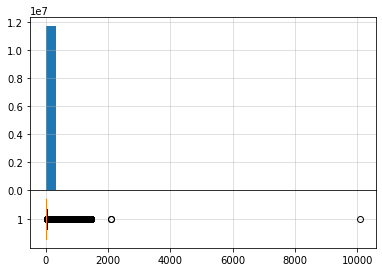

In [78]:
data_distribution(taxi_data['duration'],'duration')

##### Moze se primjetiti ocigledan outlier koji ce se izbaciti
Takodje i sve vrijednosti duzine trajanja koje su vece od 3000min (50h) ce biti izbacene

In [72]:
#izbacivanje outliera za duration>=3000min (50h)
taxi_data=taxi_data[taxi_data['duration']<3000]

In [73]:
taxi_data["duration"].describe()

count    1.174614e+07
mean     1.685524e+01
std      5.479815e+01
min      1.666667e-02
25%      6.866667e+00
50%      1.153333e+01
75%      1.893333e+01
max      2.098233e+03
Name: duration, dtype: float64

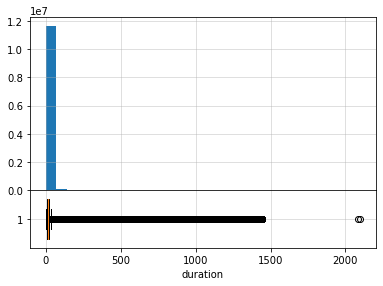

In [74]:
data_distribution(taxi_data['duration'],'duration')

##### I dalje postoje outlier-i
Te se i te vrijednosti izbacuju

In [75]:
taxi_data=taxi_data[taxi_data['duration']<1500]

<h3>Kombinacija duration i trip_distance </h3>

<h4><font color="green">FUNCKIJA - za iscrtavanje scatter plota</font></h4>
<hr>

In [76]:
def scatter_plot(x_data, y_data, x_label, y_label):
   
    x = np.array(x_data)
    y = np.array(y_data)
    
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

<hr>

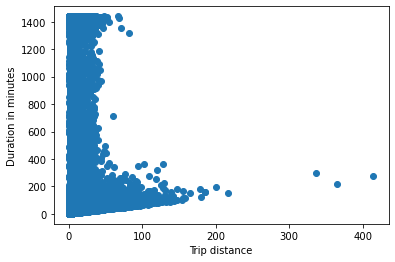

In [77]:
scatter_plot(taxi_data['trip_distance'], taxi_data['duration'], 'Trip distance', 'Duration in minutes')

##### Realna situacijia na ovom scatter plot-u bi bila da kako raste razdaljina tako i vrijeme trajanja prevoza

Tri tacke koje se nalaze skroz desno jedu realne vrijednosti kombinacije ovih obiljezja, jer njujork sam po sebi je
dugacak oko 530km a sirok oko 455km. Takodje nije ni nerealno preci toliku razdaljinu za oko 5-7 sati, pogotovo ako se prevoz krece autoputom.

Zato sa druge strane nerealna predstava je bilo koja kombinacija trajanja koja je vezana za skoro 0km predjenih

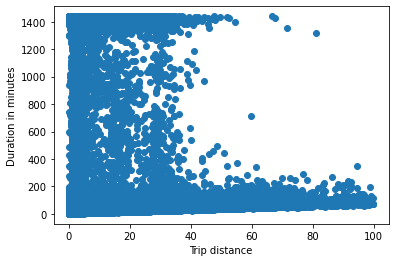

In [58]:
scatter_plot(taxi_data['trip_distance'][(taxi_data["trip_distance"] <= 100)],
             taxi_data['duration'][(taxi_data["trip_distance"] <= 100)],
             'Trip distance', 'Duration in minutes')


##### Na scatter plot-u iznad je pogotovo primjetljivo da za ogromne vrijednosti trajanja (600-1400 min) da je predjena kilometraza svega do 20km

In [78]:
percent = taxi_data['duration'][(taxi_data["duration"] > 600)].count()/taxi_data['duration'].count()*100
print("Procenat voznji cije je trajanje vece od 800min (~13h): ", percent, "%")

Procenat voznji cije je trajanje vece od 800min (~13h):  0.14804869857191322 %


##### Ovim se moze zakljuciti da za sve te ogromne vrijednosti trajanja voznje vozilo bi se kretalo premalim srednjim brzinama
(npr. za duration=600min=10h i trip_distance=10km, avg_speed=1km/h sto je veoma nerealno)
<br>
Iz toga razloga ce se izbaciti sve voznje cije su srednje brzine <=5km/h

In [79]:
#izbacivanje voznji sa prosjecnom brzinom manjom od 5
taxi_data = taxi_data[(taxi_data["avg_speed"] >5)]

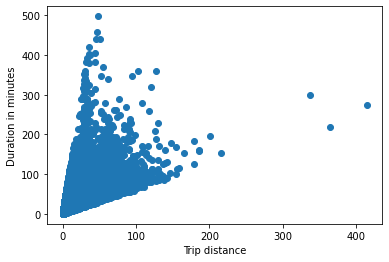

In [61]:
scatter_plot(taxi_data['trip_distance'], taxi_data['duration'], 'Trip distance', 'Duration in minutes')

Kao sto smo i prethodno naveli, ove tri tacke koje se nalaze skroz desno nisu nerealne vrijednosti, ali posto su samo tri tacke u pitanju, njih cemo takodje izbaciti, jer nece uticati na konacni rezultat

In [80]:
taxi_data=taxi_data[taxi_data['trip_distance']<250]

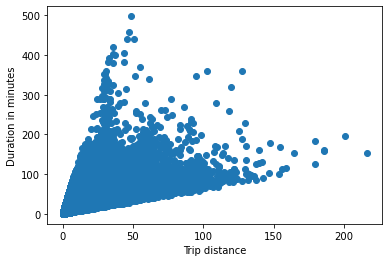

In [81]:
scatter_plot(taxi_data['trip_distance'], taxi_data['duration'], 'Trip distance', 'Duration in minutes')

### Fare amount

In [82]:
taxi_data['fare_amount'].describe()

count    1.158410e+07
mean     1.331517e+01
std      1.140100e+01
min      1.000000e-02
25%      6.500000e+00
50%      9.500000e+00
75%      1.550000e+01
max      8.007000e+03
Name: fare_amount, dtype: float64

Nakon sto su izbacene cijene koje su <=0, vidimo da postoji minimalna cijena od 0.01\$. To ne bi trebao da je validan podatak jer se na osnovu istrazivanja cijena taksija (https://www.sciencedirect.com/science/article/pii/S096585642030762X ) za 2016. godinu pocetna cijena 2.5$. 

In [65]:
print('Broj voznji sa cijenom manjom od 2.5$ je: ',taxi_data['fare_amount'][taxi_data['fare_amount']<2.5].count())

Broj voznji sa cijenom manjom od 2.5$ je:  583


Izbacicemo sve voznje cije su cijene manje od 2.5$

In [83]:
taxi_data=taxi_data[taxi_data['fare_amount']>=2.5]

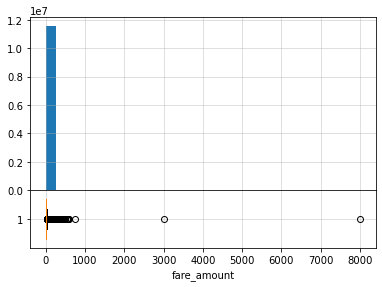

In [84]:
data_distribution(taxi_data['fare_amount'],'fare_amount')

In [68]:
taxi_data[taxi_data['fare_amount']>=600]

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,week_day,day_type,day_time_slot,duration,avg_speed
654974,1,2,0.4827,5,138,138,2,740.0,2016-05-02,19:16:07,2016-05-02,19:17:37,0,1.0,5,1.500000,19.308000
1923543,1,1,1.6090,5,125,158,3,600.0,2016-05-05,22:17:26,2016-05-05,22:21:32,3,1.0,6,4.100000,23.546341
3601104,1,1,2.5744,1,264,264,2,8007.0,2016-05-10,07:14:37,2016-05-10,07:22:45,1,1.0,1,8.133333,18.991475
4293380,1,1,2.8962,1,264,264,3,3006.0,2016-05-11,22:26:52,2016-05-11,22:32:08,2,1.0,6,5.266667,32.994684


Na osnovu dijagrama i tabele vidimo da postoje autlajeri sa cijenama voznje preko 600\$, pri cemu su one trajale manje od 15min. Takodje postoji i voznja koja je trajala preko 7 sati za razdaljinu od 7km, sto se ne cini kao validan podataka. Ovi autlajeri ce biti izbaceni.

In [85]:
#izbacivanje prethodno prikazanih autlajera
taxi_data=taxi_data[taxi_data['fare_amount']<600]

In [86]:
taxi_data['fare_amount'].describe()

count    1.158351e+07
mean     1.331477e+01
std      1.111827e+01
min      2.500000e+00
25%      6.500000e+00
50%      9.500000e+00
75%      1.550000e+01
max      5.740000e+02
Name: fare_amount, dtype: float64

C:\Users\Natalija\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

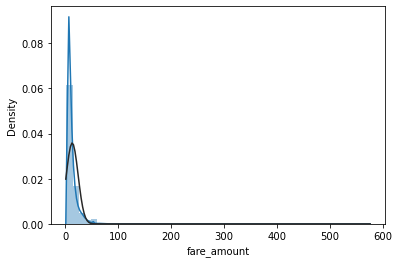

In [71]:
#raspodjela u uporedbi sa normalnom raspodjelom nad skracenim skupom podataka
sb.distplot(taxi_data['fare_amount'], fit=norm)

Iz raspodjele se vidi da je desno asimetricna odnosno i dalje postoji odredjen broj vrijednsoti koje su znatno vece u odnosu na najcesce vrijednosti koje su od 6.5 do 15. (interkvartilni opseg ) . Iz tog razloga je srednja vrijendost od 13. veca od medijana koji je 9.5\$, ali to nije toliko znacajna razlika.

In [87]:
taxi_data['fare_amount'][taxi_data['fare_amount']>200].count()

482

In [88]:
#Izbacivanje voznji sa fare_amount vecim od 200$
taxi_data=taxi_data[taxi_data['fare_amount']<=200]

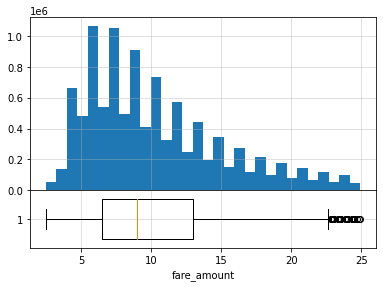

In [74]:
#prikaz distribucije za vrijednosti koje ne predstavljaju potencijalne autlajere (izmedju krajnjih linija)
data_distribution(taxi_data['fare_amount'][taxi_data['fare_amount']<25],'fare_amount')

<h3> Kombinacija cijene sa razdaljinom i cijene sa trajanjem </h3>

Text(0, 0.5, 'duration')

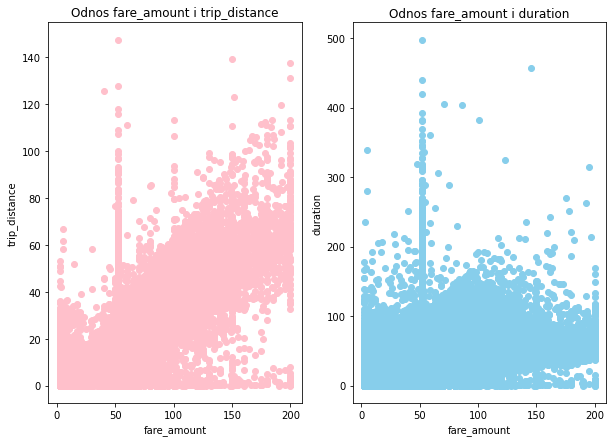

In [89]:
#uporedjivanje
fig, ax = plt.subplots(1,2,figsize=(10,7))
ax[0].scatter(taxi_data['fare_amount'],taxi_data['trip_distance'], color='pink')
ax[0].set_title('Odnos fare_amount i trip_distance')
ax[1].scatter(taxi_data['fare_amount'],taxi_data['duration'], color='skyblue')
ax[1].set_title('Odnos fare_amount i duration')

ax[0].set_xlabel('fare_amount')
ax[0].set_ylabel('trip_distance')
ax[1].set_xlabel('fare_amount')
ax[1].set_ylabel('duration')

Moze se primjetiti da postoji veliki broj voznji koje imaju mali trip_distance(manje od 1km)za fare_amount preko 20. Takodje isto vazi i za trajanje voznje gdje se neke naplacuju vise od 20$ a nisu trajale ni minut

Pored toga mogu se primjetiti i nevalidni podacci koji idu u drugu krajnost odnosno da su voznje za preko 40km i koju su trajale vise od 3h naplacivane manje od 5$

<font color='royalblue'><h3>Analiza  na osnovu vremenskih perioda</h3></font>

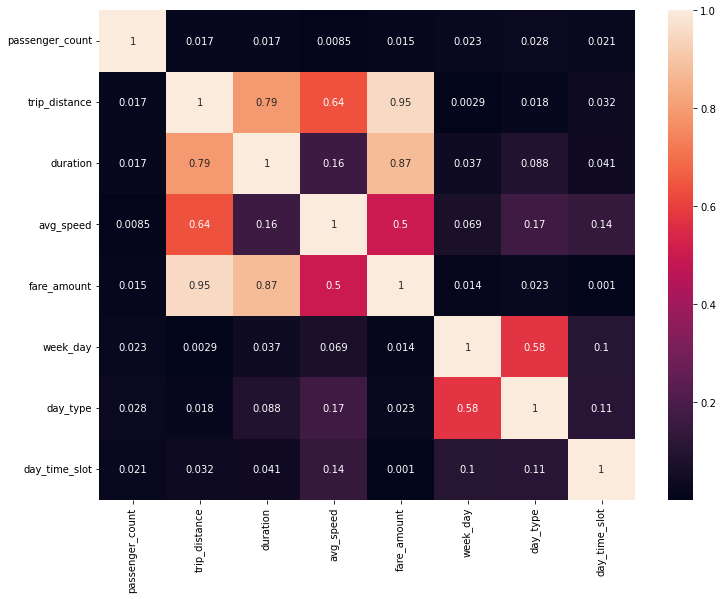

In [93]:
#korelacija obilježja
corr = taxi_data[['passenger_count','trip_distance','duration','avg_speed','fare_amount','week_day','day_type','day_time_slot']].corr()
f = plt.figure(figsize=(12, 9))
sb.heatmap(corr.abs(), annot=True);

Na osnovu dijagrama korelacije izmedju obiljezja moze se uociti da broj putnika ne utice na druge varijable pa se nece dodatno analizirati. <br>
-Kao sto se vidjelo ranije duzina puta je u visokoj i pozitivnoj korelaciji sa trajanjem voznje i cijenom.<br>
-Brzina ima uticaj na cijenu ali vise na duzinu puta 

In [94]:
#novi setovi za tip dana u sedmici
workday=taxi_data[taxi_data['day_type']==1] 
weekend=taxi_data[taxi_data['day_type']==2] 
holiday=taxi_data[taxi_data['day_type']==3] 

In [95]:
#novi setovi po danu u sedmici
monday=taxi_data[taxi_data['week_day']==0] 
tuesday=taxi_data[taxi_data['week_day']==1] 
wednesday=taxi_data[taxi_data['week_day']==2] 
thursday=taxi_data[taxi_data['week_day']==3] 
friday=taxi_data[taxi_data['week_day']==4] 
saturday=taxi_data[taxi_data['week_day']==5] 
sunday=taxi_data[taxi_data['week_day']==6] 

In [96]:
#novi setovi po vremenu u toku dana
early_morning=taxi_data[taxi_data['day_time_slot']==1] 
late_morning=taxi_data[taxi_data['day_time_slot']==2]
early_afternoon=taxi_data[taxi_data['day_time_slot']==3]
late_afternoon=taxi_data[taxi_data['day_time_slot']==4]
evening=taxi_data[taxi_data['day_time_slot']==5]
night=taxi_data[taxi_data['day_time_slot']==6]

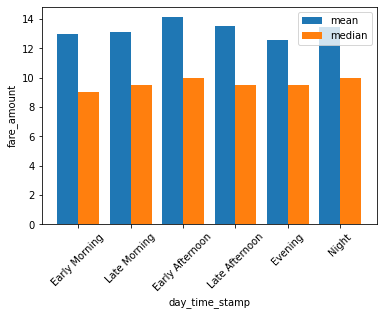

In [97]:
#Prikaz uporedbe srednje vrijednosti i medijana za cijenu puta u odnosu na period dana
X = ['Early Morning','Late Morning','Early Afternoon','Late Afternoon','Evening','Night']
Y = [early_morning['fare_amount'].mean(),late_morning['fare_amount'].mean(),
     early_afternoon['fare_amount'].mean(),late_afternoon['fare_amount'].mean(),evening['fare_amount'].mean(),night['fare_amount'].mean()]
Z = [early_morning['fare_amount'].median(),late_morning['fare_amount'].median(),
     early_afternoon['fare_amount'].median(),late_afternoon['fare_amount'].median(),evening['fare_amount'].median(),night['fare_amount'].median()]
 
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'mean',)
plt.bar(X_axis + 0.2, Z, 0.4, label = 'median')
  
plt.xticks(X_axis, X,rotation=45)
plt.xlabel("day_time_stamp")
plt.ylabel("fare_amount")
plt.legend()

Na osnovu dijagrama iznad moze se uociti da se prosjecna cijena kao ni medijana ne mijanjaju drasticno u odnosu na period dana. Iako bi se ocekivalo da je cijena najveca nocu, ipak je malo veca za Early Afternoon dnosno od 1 do 3

Text(0.5, 0.98, 'prikaz cijena voznja prema tipu dana')

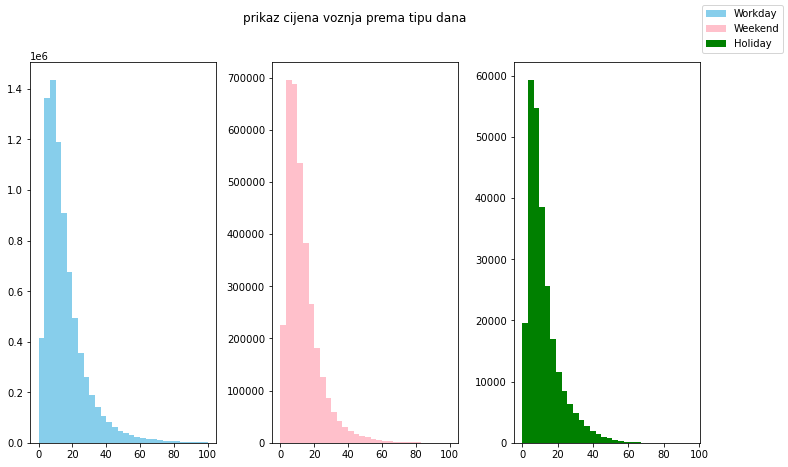

In [98]:
#raspodjela cijene voznje u odnosu na tip dana
fig, ax = plt.subplots(1, 3, figsize=[12,7])
fig.subplots_adjust(hspace=0.2, wspace=0.3)

ax[0].hist(workday['duration'][workday['duration']<100],color='skyblue', label = "Workday",bins=30)
ax[1].hist(weekend['duration'][weekend['duration']<100],color='pink', label="Weekend",bins=30)
ax[2].hist(holiday['duration'][holiday['duration']<100], color='green', label='Holiday',bins=30)
fig.legend()
fig.suptitle("prikaz cijena voznja prema tipu dana")

Na osnovu dijagrama iznad ne moze se uociti odredjeni trend u cijenama voznji tokom mjeseca. Postoje odredjene oscilacije ali slicne su vrijednsoti i za pocetak i kraj mjeseca.

C:\Users\Natalija\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Natalija\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Natalija\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

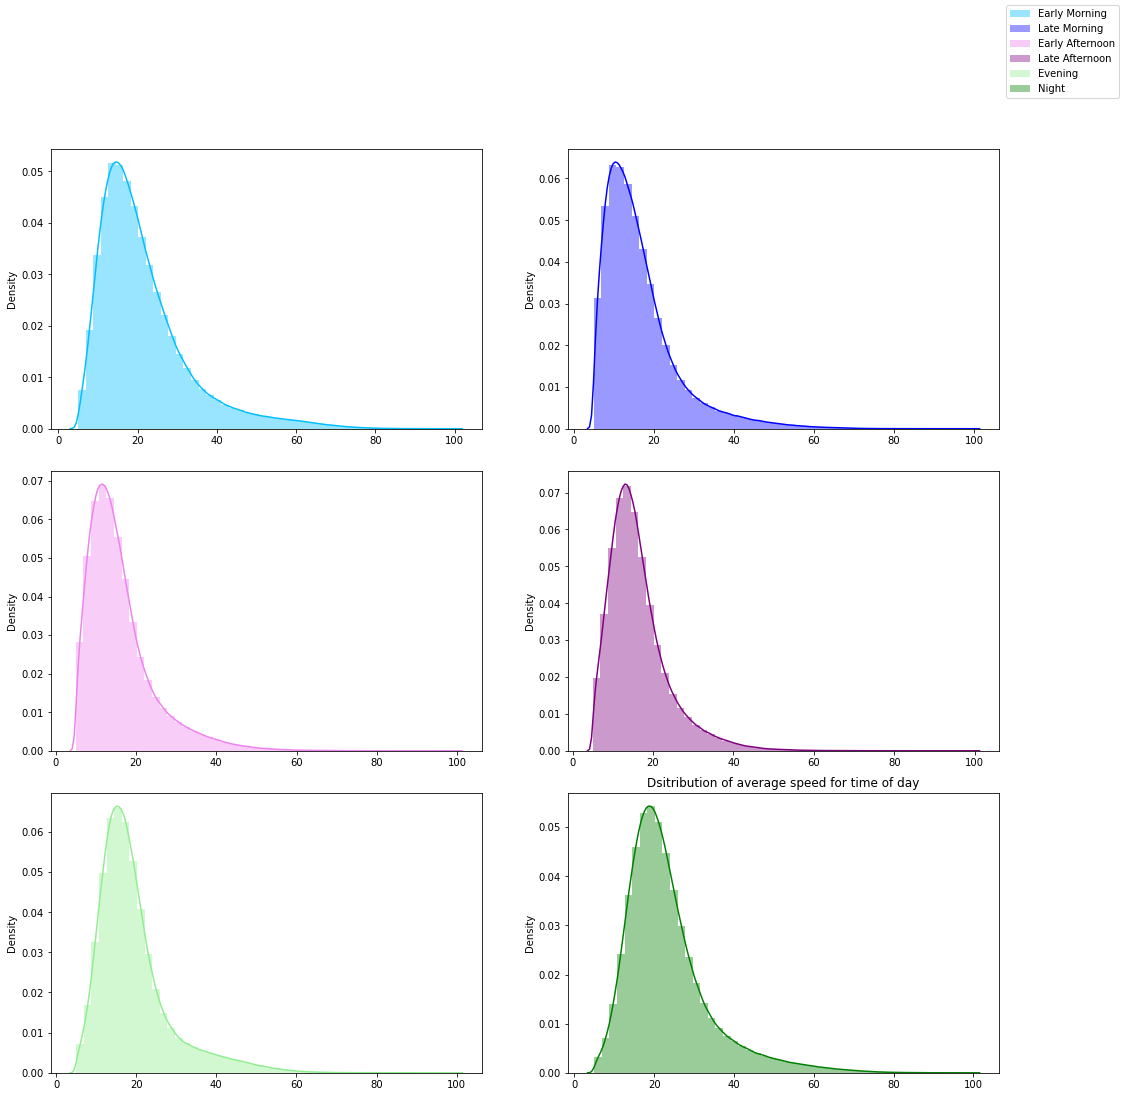

In [89]:
# Distribution of speed vs. time of day
fig, ax = plt.subplots(3, 2, figsize=[17,17])
fig.subplots_adjust(hspace=0.15, wspace=0.2)

sb.distplot(x=early_morning['avg_speed'],label='Early Morning',ax=ax[0,0],color='deepskyblue')
sb.distplot(x=late_morning['avg_speed'],label='Late Morning',ax=ax[0,1],color='blue')
sb.distplot(x=early_afternoon['avg_speed'],label='Early Afternoon',ax=ax[1,0],color='violet')
sb.distplot(x=late_afternoon['avg_speed'],label='Late Afternoon',ax=ax[1,1],color='purple')
sb.distplot(x=evening['avg_speed'],label='Evening',ax=ax[2,0],color='lightgreen')
sb.distplot(x=night['avg_speed'],label='Night',ax=ax[2,1],color='green')
fig.legend()
plt.title('Dsitribution of average speed for time of day');

Kada se uporede raspodjele prosjecne brzine po periodima dana, moze se primjetiti da su jako slicne ali se moze uociti da je noci distribucija pomjerena vise u desno odnosno brzine su vece i vise je uzoraka koji imaju brzinu preko 50,60. <br>
U periodu Early i late Afternoon se uocava veci broj uzoraka sa slicnim brzinama oko 15km/h, sto bi se moglo objasniti guzvama u gradu koje tada vladaju zbog posla i skole. 

[]

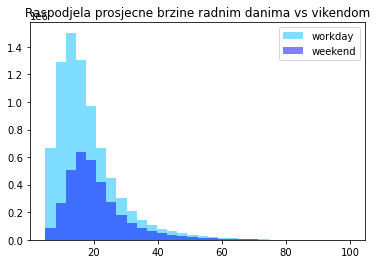

In [99]:
#prikaz raspodjele prosjecne brzine za radne dane i vikende
fig = plt.figure()
# histogram
ax = plt.hist(workday['avg_speed'], bins=30,alpha=0.5, color='deepskyblue',label='workday')
ax = plt.hist(weekend['avg_speed'], bins=30,alpha=0.5, color='blue',label='weekend')
plt.title('Raspodjela prosjecne brzine radnim danima vs vikendom')
plt.legend()
plt.plot()

Prosjecna brzina takodje ima istu raspodjelu za radne dane i vikend

<AxesSubplot:xlabel='day_time_slot', ylabel='count'>

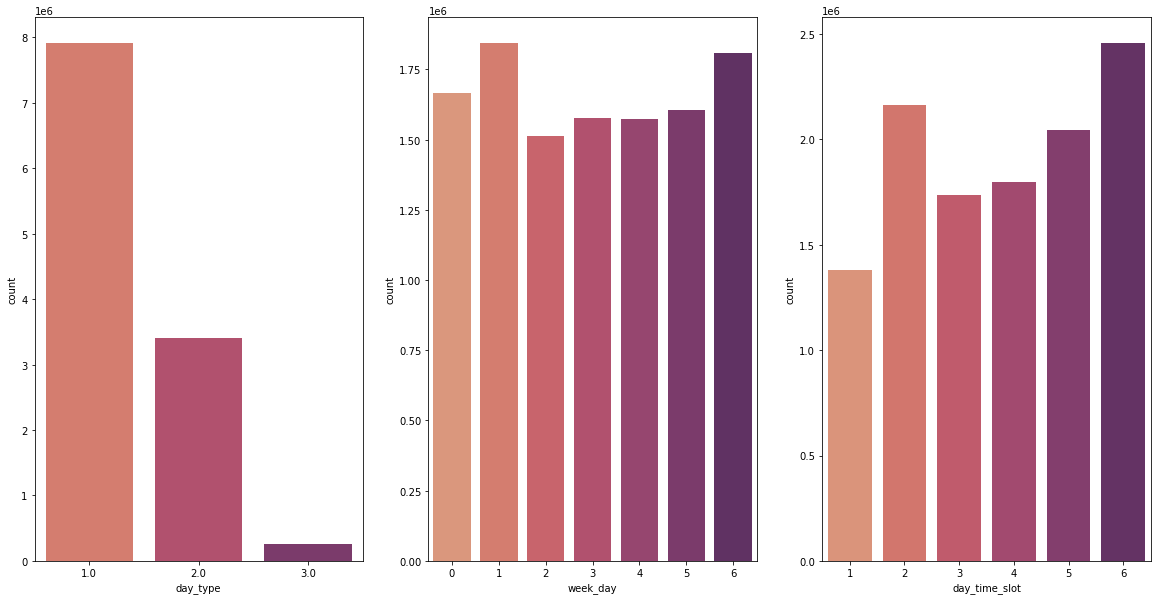

In [100]:
#broj voznji u odnosu na vremenske odrednice tokom sedmice i dana
fig, ax = plt.subplots(1, 3, figsize=[20,10])
fig.subplots_adjust(hspace=0.2, wspace=0.2)

sb.countplot(x=taxi_data["day_type"],ax=ax[0],palette='flare')
sb.countplot(x=taxi_data["week_day"],ax=ax[1],palette='flare')
sb.countplot(x=taxi_data["day_time_slot"],ax=ax[2],palette='flare')

Iako je ocekivano da ce broj voznji biti veci radnim danima zapravo imamo skok tokom nedelje u odnosu na druge dane. <br>
Sto se tice perioda u jednom danu najvise taksi voznji je bilo u nocnom periodu odnosno izmedju 21h i 4h.

<font color='royalblue'><h3>Cuvanje preciscenih podataka</h3></font>

In [101]:
print('Broj obiljezja u preciscenom dataset-u: ',taxi_data.shape[0])

Broj obiljezja u preciscenom dataset-u:  11583030


In [102]:
taxi_data.dtypes

VendorID             int64
passenger_count      int64
trip_distance      float64
RatecodeID           int64
PULocationID         int64
DOLocationID         int64
payment_type         int64
fare_amount        float64
pickup_date         object
pickup_time         object
dropoff_date        object
dropoff_time        object
week_day             int64
day_type           float64
day_time_slot        int64
duration           float64
avg_speed          float64
dtype: object

In [104]:
taxi_data['pickup_date']=taxi_data['pickup_date'].astype(str)

In [106]:
taxi_data['pickup_time']=taxi_data['pickup_time'].astype(str)
taxi_data['dropoff_date']=taxi_data['dropoff_date'].astype(str)
taxi_data['dropoff_time']=taxi_data['dropoff_time'].astype(str)

In [107]:
#Cuvanje preciscenjih podataka u odvojen csv
taxi_data.to_parquet('yellow_tripdata_2016-05_CLEANED.parquet')

<font color='blueviolet'><h2>Weather Data Importing</h2></font>

In [111]:
#ucitavanje podataka o vremenskim uslovima za New York
temperature=pd.read_csv('temperature.csv')[['datetime','New York']]
humidity=pd.read_csv('humidity.csv')[['datetime','New York']]
pressure=pd.read_csv('pressure.csv')[['datetime','New York']]
weather_description=pd.read_csv('weather_description.csv')[['datetime','New York']]
wind_speed=pd.read_csv('wind_speed.csv')[['datetime','New York']]

### Temperature

In [112]:
temperature.head()

,datetime,New York
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,288.220000
2,2012-10-01 14:00:00,288.247676
3,2012-10-01 15:00:00,288.326940
4,2012-10-01 16:00:00,288.406203


In [113]:
temperature.dtypes

datetime     object
New York    float64
dtype: object

In [114]:
#promjena tipa obiljezja datetime radi razdvajanje datuma od vremena
temperature['datetime'] = pd.to_datetime(temperature['datetime'])

In [115]:
#razdvajanje datetim na datum i sat
temperature['date']=temperature['datetime'].dt.date
temperature['hour']=temperature['datetime'].dt.hour
temperature.drop('datetime',inplace=True,axis=1)

In [116]:
temperature.head()

,New York,date,hour
0,NaN,2012-10-01,12
1,288.220000,2012-10-01,13
2,288.247676,2012-10-01,14
3,288.326940,2012-10-01,15
4,288.406203,2012-10-01,16


In [117]:
#izdvajanje podataka za maj 2016.godine
import datetime
temperature=temperature[(temperature['date']>=datetime.date(2016,5,1)) & (temperature['date']<= datetime.date(2016,5,31))]

In [118]:
#Nedostajuci podaci po obiljezjima
temperature.isnull().sum()

New York    0
date        0
hour        0
dtype: int64

In [119]:
#primenovanje kolone za temperaturu radi spajanja sa drugim vremenskim obiljezjima u jedan datasetb
temperature.rename(columns={'New York':'temperature'},inplace=True)

In [120]:
temperature['temperature'].describe()

count    744.000000
mean     289.021680
std        6.058009
min      277.450000
25%      284.147500
50%      287.750000
75%      293.512500
max      304.990000
Name: temperature, dtype: float64

Na osnovu vrijednosti podataka moze se zakljuciti da su temperature izrazene u kelvinima. Pretvoricemo ih u celzijuse

In [121]:
#pretvaranje K u C
temperature['temperature']=temperature['temperature']-272.15

### Humidity


In [122]:
humidity.head()

,datetime,New York
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,58.0
2,2012-10-01 14:00:00,57.0
3,2012-10-01 15:00:00,57.0
4,2012-10-01 16:00:00,57.0


In [123]:
#promjena tipa obiljezja datetime radi razdvajanje datuma od vremena
humidity['datetime'] = pd.to_datetime(humidity['datetime'])
#razdvajanje datetime  na datum i vrijeme
humidity['date']=humidity['datetime'].dt.date
humidity['hour']=humidity['datetime'].dt.hour
humidity=humidity[(humidity['date']>=datetime.date(2016,5,1)) & (humidity['date']<= datetime.date(2016,5,31))]
humidity.drop('datetime',inplace=True,axis=1)

In [124]:
humidity.rename(columns={'New York': 'humidity'},inplace=True)

In [125]:
humidity.isnull().sum()

humidity    0
date        0
hour        0
dtype: int64

In [126]:
humidity['humidity'].describe()

count    744.000000
mean      69.856183
std       21.293489
min       21.000000
25%       53.000000
50%       75.000000
75%       88.000000
max      100.000000
Name: humidity, dtype: float64

Na osnovu statistickih podataka na prvu se ne uocavaju autlajeri jer su min i max vrijednosti realne, a i srednja vrijednost i medijana su priblizne

### Pressure

In [127]:
#promjena tipa obiljezja datetime radi razdvajanje datuma od vremena
pressure['datetime'] = pd.to_datetime(pressure['datetime'])
#razdvajanje datetime  na datum i vrijeme
pressure['date']=pressure['datetime'].dt.date
pressure['hour']=pressure['datetime'].dt.hour
pressure=pressure[(pressure['date']>=datetime.date(2016,5,1)) & (pressure['date']<= datetime.date(2016,5,31))]
pressure.drop('datetime',inplace=True,axis=1)

In [128]:
pressure.rename(columns={'New York': 'pressure'},inplace=True)

In [129]:
pressure.isnull().sum()

pressure    0
date        0
hour        0
dtype: int64

In [130]:
pressure['pressure'].describe()

count     744.000000
mean     1014.833333
std         5.504108
min      1003.000000
25%      1010.000000
50%      1016.000000
75%      1019.000000
max      1025.000000
Name: pressure, dtype: float64

Kao i u slucaju vlaznosti vazduha, pritisak za maj mjesec je u ocekivanom opsegu

### Wind Speed

In [131]:
#promjena tipa obiljezja datetime radi razdvajanje datuma od vremena
wind_speed['datetime'] = pd.to_datetime(wind_speed['datetime'])
#razdvajanje datetime  na datum i vrijeme
wind_speed['date']=wind_speed['datetime'].dt.date
wind_speed['hour']=wind_speed['datetime'].dt.hour
wind_speed=wind_speed[(wind_speed['date']>=datetime.date(2016,5,1)) & (wind_speed['date']<= datetime.date(2016,5,31))]
wind_speed.drop('datetime',inplace=True,axis=1)

In [132]:
wind_speed=wind_speed.rename(columns={'New York': 'wind_speed'})

In [133]:
wind_speed.isnull().sum()

wind_speed    0
date          0
hour          0
dtype: int64

In [134]:
wind_speed['wind_speed'].describe()

count    744.000000
mean       3.116935
std        2.039590
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       13.000000
Name: wind_speed, dtype: float64

### Weather Description

In [135]:
#promjena tipa obiljezja datetime radi razdvajanje datuma od vremena
weather_description['datetime'] = pd.to_datetime(weather_description['datetime'])
#razdvajanje datetime  na datum i vrijeme
weather_description['date']=weather_description['datetime'].dt.date
weather_description['hour']=weather_description['datetime'].dt.hour
weather_description=weather_description[(weather_description['date']>=datetime.date(2016,5,1)) & (weather_description['date']<= datetime.date(2016,5,31))]
weather_description.drop('datetime',inplace=True,axis=1)

In [136]:
weather_description=weather_description.rename(columns={'New York': 'weather_description'})

In [137]:
weather_description.isnull().sum()

weather_description    0
date                   0
hour                   0
dtype: int64

In [138]:
weather_description['weather_description'].unique().tolist()

['broken clouds',
 'scattered clouds',
 'sky is clear',
 'mist',
 'drizzle',
 'light intensity drizzle',
 'fog',
 'haze',
 'light rain',
 'overcast clouds',
 'moderate rain',
 'few clouds',
 'thunderstorm with light rain',
 'thunderstorm',
 'proximity thunderstorm']

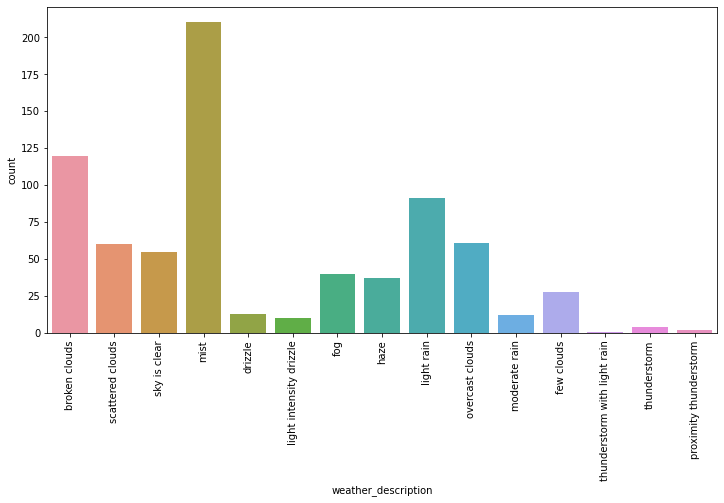

In [139]:
#prikaz broja sati po odredjenoj kategoriji vremenskog stanja
plt.figure(figsize=(12,6))
sb.countplot(x=weather_description["weather_description"])
plt.xticks(rotation=90)
plt.show()

Kao sto je prikazano na dijagramu moze se uociti da postoji najvise uzoraka tj. sati tokom kojih je bila magla, a poslije i nebo prekriveno oblacima koji obicno ne donose padavine. Vidi se da je malo uzoraka kada je bilo nevrijeme i padala kisa.

<font color='blueviolet'><h2>Weather Data Merging</h2></font>

In [140]:
#spajanje svih vremenskih karakteristika u jedan dataset
weather = (temperature.merge(humidity, on=['date','hour']).
                        merge(pressure, on=['date','hour']).
                        merge(wind_speed, on=['date','hour']).
                        merge(weather_description, on=['date','hour']))

In [141]:
weather

,temperature,date,hour,humidity,pressure,wind_speed,weather_description
0,14.12,2016-05-01,0,50.0,1023.0,5.0,broken clouds
1,12.63,2016-05-01,1,58.0,1024.0,4.0,scattered clouds
2,11.53,2016-05-01,2,70.0,1024.0,2.0,sky is clear
3,10.57,2016-05-01,3,65.0,1024.0,2.0,mist
4,10.44,2016-05-01,4,75.0,1024.0,2.0,mist
...,...,...,...,...,...,...,...
739,28.74,2016-05-31,19,54.0,1014.0,0.0,scattered clouds
740,28.97,2016-05-31,20,61.0,1013.0,3.0,broken clouds
741,29.19,2016-05-31,21,58.0,1013.0,6.0,scattered clouds
742,28.58,2016-05-31,22,33.0,1013.0,2.0,broken clouds


<h3>Analiza podataka o vremenskim uslovima</h3>

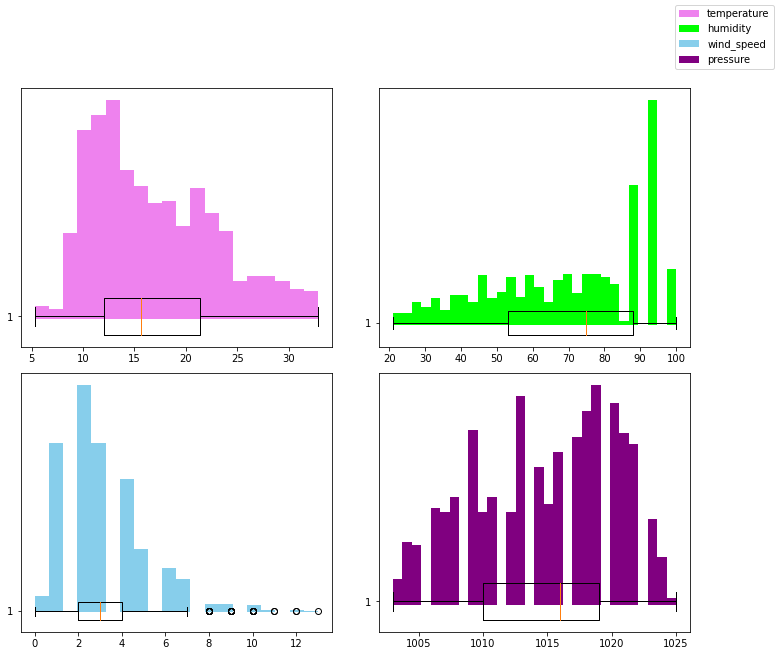

In [142]:
fig,ax=plt.subplots(2,2,figsize=(12,10))
fig.subplots_adjust(hspace=0.1, wspace=0.15)

ax[0,0].hist(weather['temperature'],bins=20,color='violet',label='temperature')
ax[0,0].boxplot(weather['temperature'], vert=False, widths=15)
ax[0,1].hist(weather['humidity'],bins=30,label = "humidity",color='lime')
ax[0,1].boxplot(weather['humidity'], vert=False, widths=15)
ax[1,0].hist(weather['wind_speed'],bins=20,color='skyblue',label='wind_speed')
ax[1,0].boxplot(weather['wind_speed'], vert=False, widths=15)
ax[1,1].hist(weather['pressure'],bins=30,color='purple',label="pressure")
ax[1,1].boxplot(weather['pressure'], vert=False, widths=10)

fig.legend()

Na grafiku iznad prikazane su raspodjele za temperaturu, vlaznost vazduha, pritisak i brzinu vjetra.<br> 
Temperatura se krece od 5 do 30 °C, ali je vecina uzoraka od oko 15 do 20 °C. Nema autlajera. <br>
Sto se tice vlaznosti vazduha vecinom je izmedju 55 i 90%, ali postoji i i par visokih vrijednosti do cak 100%. <br>
Brzina vjetra je izmedju 2 i 4 m/s, ali postoje autlajeri sa vrijednostima iznad 8. <br>
Pritisak vazduha je sa pribliznim vrijednostima u intervalu od 1000 do 1025 Pa


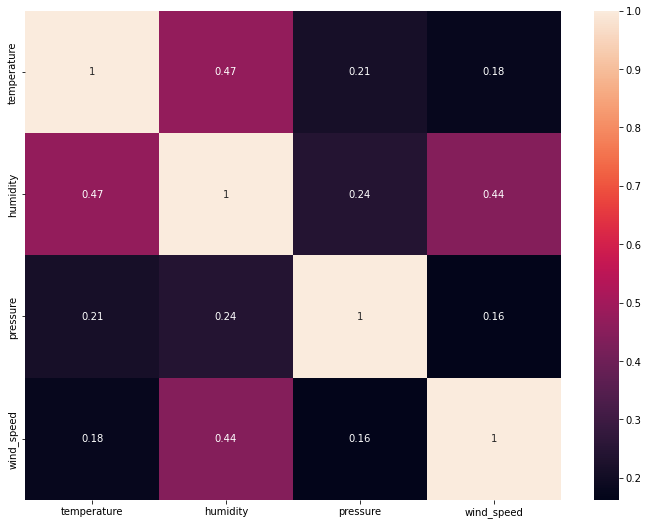

In [143]:
#korelacija izmedju vremenskih parametara
corr = weather[['temperature','humidity','pressure','wind_speed']].corr()
f = plt.figure(figsize=(12, 9))
sb.heatmap(corr.abs(), annot=True);

S obzirom da su najvise korelisana obiljezja za pritisak, temperaturu i brzinu vjetra, u nastavku ce se posmatrati njihove kombinacije

Text(0, 0.5, 'wind_speed')

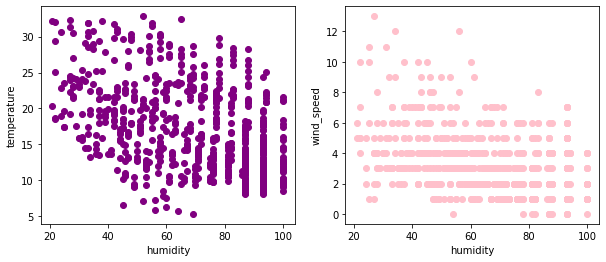

In [144]:
#prikaz zavisnosti korelisanih obiljezja medjusobno
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(weather['humidity'],weather['temperature'], color='purple')
ax[0].set_xlabel('humidity')
ax[0].set_ylabel('temperature')

ax[1].scatter(weather['humidity'],weather['wind_speed'], color='pink')
ax[1].set_xlabel('humidity')
ax[1].set_ylabel('wind_speed')

Vlaznost vazduha je negativno korelisana u odnosu na temperatutu i brzinu vjetra odnosno ukoliko se oni povecaju vlaznost opada u odredjenoj mjeri

<font color='blueviolet'><h2>Spajanje Taxi Data sa Weather Data</h2></font>

In [145]:
#dodavanje obiljezja za sat u kom je zovnja pocela koji je zakoruzen na osnovu minuta i sekundi
taxi_data["pickup_hour"] = (pd.to_datetime(taxi_data['pickup_time'], format='%H:%M:%S')).dt.round("H").dt.hour

In [146]:
taxi_data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,week_day,day_type,day_time_slot,duration,avg_speed,pickup_hour
2,1,1,1.4481,1,166,238,2,5.5,2016-05-01,00:01:47,2016-05-01,00:05:27,6,2.0,6,3.666667,23.696182,0
3,1,1,3.2180,1,151,74,2,11.0,2016-05-01,00:11:46,2016-05-01,00:25:35,6,2.0,6,13.816667,13.974427,0
4,1,2,8.3668,1,74,129,2,15.5,2016-05-01,00:30:45,2016-05-01,00:40:08,6,2.0,6,9.383333,53.499964,1
5,1,1,4.5052,1,41,263,1,12.5,2016-05-01,00:17:15,2016-05-01,00:32:21,6,2.0,6,15.100000,17.901457,0
6,1,1,3.3789,1,142,246,2,9.5,2016-05-01,00:51:36,2016-05-01,01:01:58,6,2.0,6,10.366667,19.556334,1


In [154]:
weather.dtypes

temperature            float64
date                    object
hour                     int64
humidity               float64
pressure               float64
wind_speed             float64
weather_description     object
dtype: object

In [153]:
weather['date']=weather['date'].astype(str)

In [155]:
#spajanje podataka o taksi voznjama i vremenu za taj period
df = (taxi_data.merge(weather, left_on =['pickup_date','pickup_hour'],right_on=['date','hour']))

In [157]:
df.drop(columns=['pickup_hour','date','hour'],axis=1,inplace=True)

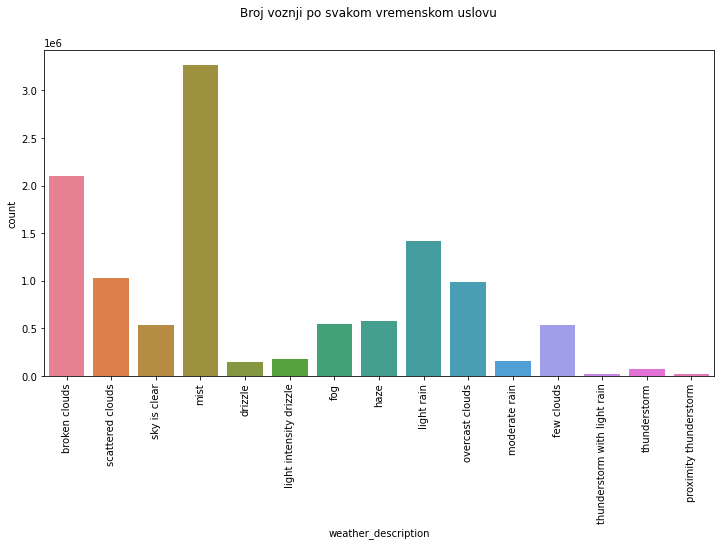

In [159]:
#broj voznji za svaki vremenski opis
plt.figure(figsize=(12,6))
sb.countplot(x=df["weather_description"],palette='husl')
plt.xticks(rotation=90)
plt.suptitle('Broj voznji po svakom vremenskom uslovu')
plt.show()

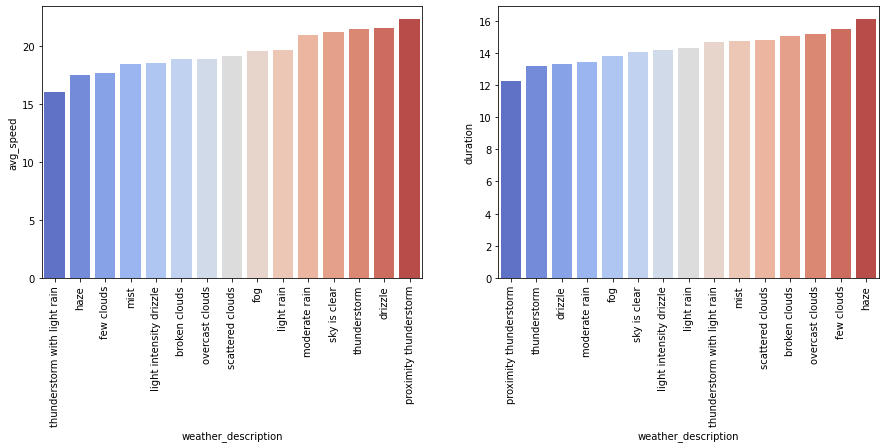

In [160]:
#prikaz proscjecnih brzina i duzine trajanja voznje po vremenskim uslovima
fig,ax=plt.subplots(1,2,figsize=(15,5))
speed = df.groupby('weather_description').mean().sort_values('avg_speed')
duration = df.groupby('weather_description').mean().sort_values('duration')

ax0 = sb.barplot(x=speed.index,y=speed['avg_speed'],ax=ax[0],palette='coolwarm')
for item in ax0.get_xticklabels():
    item.set_rotation(90)

ax1 = sb.barplot(x=duration.index,y=duration['duration'],ax=ax[1],palette='coolwarm')
for item in ax1.get_xticklabels():
    item.set_rotation(90)

Ukoliko se posmatra prosjecna brzina po vremenskim uslovima iako je ocekivano da manje vrijednosti budu tokom kisnih sati, zapravo su vece kada su oluje i kise, dok se taksiji krecu sporije kada je zastupljena magla i sitna kisa. <br>
Sto se tice trajanja voznje one su krace takodjer po kisnom vremenu i olujama, dok su najduza trajanja za vremenske uslove bez kise ali sa oblacima.

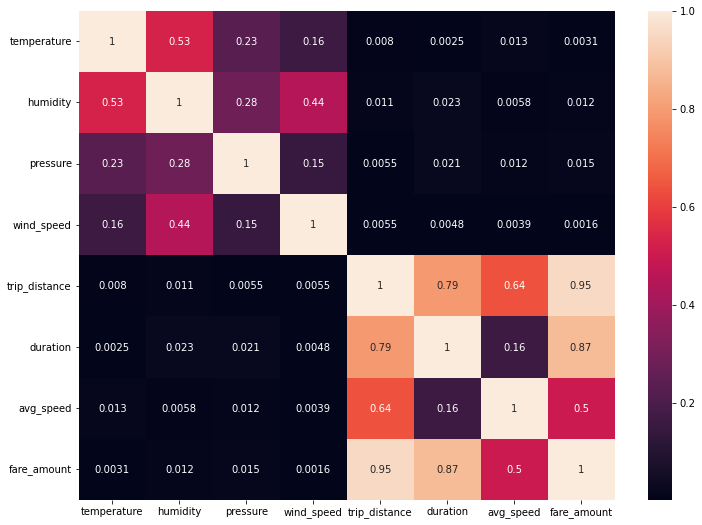

In [161]:
#korelacija izmedju vremenskih parametara i taxi voznji 
corr = df[['temperature','humidity','pressure','wind_speed','trip_distance','duration','avg_speed','fare_amount']].corr()
f = plt.figure(figsize=(12, 9))
sb.heatmap(corr.abs(), annot=True);

Na osnovu ove mape moze se zakljuciti da podacima o vremenskim prilikama zapravo ne uticu puno na parametre taksi voznje

<font color='royalblue'><h3>Cuvanje spojenih Taxi i Weather podataka</h3></font>

In [163]:
#Cuvanje preciscenjih podataka u odvojen csv
df.to_parquet('yellow_tripdata_2016-05_and_weather.parquet')